In [175]:
## import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as sci
import sympy as sy
from sklearn.metrics import r2_score
pd.set_option("display.max_rows", None)

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

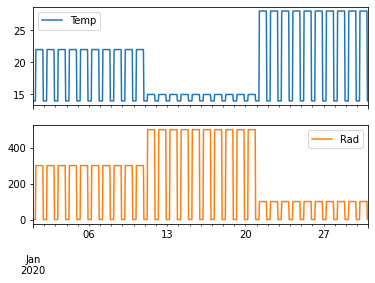

In [177]:
time_period=24*30
time=pd.date_range('2020-01-01 0:0:0',periods=time_period, freq="H")
df= pd.DataFrame(None, index = time)

DOY=df.index.strftime('%j').astype(int)

sunrise = 6
sunset = 21
df['day_night'] = df.index.hour.map(lambda h: 'day' if sunrise <= h <= sunset else 'night' )

df.loc[(df['day_night'] == 'day') , 'Temp'] = 22
df.loc[(df['day_night'] == 'night') , 'Temp'] = 14
df.loc[(df['day_night'] == 'day') & ((DOY  <= 20) &(DOY >10)), 'Temp'] = 15
df.loc[(df['day_night'] == 'day') & (20< DOY ), 'Temp'] = 28

df.loc[(df['day_night'] == 'day') & (DOY <= 10), 'Rad'] = 300
df.loc[(df['day_night'] == 'day') & ((DOY  <= 20) &(DOY >10)), 'Rad'] = 500
df.loc[(df['day_night'] == 'day') & (20< DOY ), 'Rad'] = 100
df= df.fillna(0)

df.plot(subplots=True) #.iloc[:24*6*5,:]

In [84]:
def day_time_length(df):
    radiation_threshold = 100
    daytime_length = 0
    df_day= df.resample('1D').mean()
    for i in range(len(df)):
        if df.iloc[i]['Rad'] > radiation_threshold:
            if i > 0 and df.iloc[i-1]['Rad'] <= radiation_threshold:
                start_time = df.index[i]
            if i < len(df)-1 and df.iloc[i+1]['Rad'] <= radiation_threshold:
                end_time = df.index[i]
                daytime_length += (end_time.hour - start_time.hour)
                df_day['day_len'] = daytime_length/len(df_day)
    return df_day['day_len']


In [213]:
'''
main code 
'''

#Model 1 
comp_20 = 7.32*10**(-5)
Q_10 = 2
CO2 = 400
LUE_CO2= 17*10**(-9)
con_bnd= 0.004
con_stem= 0.007
k = 0.7
Q10_resp = 2
C_resp = 3.47*10**(-7)
# W_dry = 0.2 #structure dry weight; kgDM
C_bet= 0.8 # Conversion rate from assimilate to dry matter
C_alp= 0.68 # conversion factor from carbon dioxide into sugar equivalents 
W_str1= 0.05 #structure dry weight; kgDM

#Model 2 
con_gro = 5*10**(-6)
Q10_gro =1.6
W_str2 =  0.045 #structure dry weight; kgDM
W_nsc2 = 0.05 - W_str2

#Model 3 
light_period =sunset-sunrise
W_str3= 0.045 #structure dry weight; kgDM
W_nsc3= 0.05- W_str3
W_sol = 0.002
W_starch = W_nsc3-W_sol


DAT=np.arange(0,len(df.resample('1D')))
DOY=df.index.strftime('%j').astype(int)
# LAI =  4/(1+np.exp((20-DOY) /7))
LAI = 2.5
LAI_series = pd.Series(LAI,df.index)
drymass1=[]
drymass2=[]
drymass3=[]
temp = df.Temp
rad = df.Rad
day_len_series= day_time_length(df)
sol=[]
a1 = 0
a2 =0 
p1 = 16/24


# Loop over each day in the data
for day in df.index.day.unique():
    daylen=int(day_len_series[day_len_series.index.day == day])
    # Loop over each hour of the day
    for hour in df.index.hour.unique():
        # Get the hourly value of LAI, temperature and radiation
        LAI_h = LAI_series[(LAI_series.index.day==day) & (LAI_series.index.hour==hour)].values[0]
        temp_h = df[(temp.index.day==day) & (temp.index.hour==hour)].Temp.values[0]
        rad_h = df[(rad.index.day==day) & (rad.index.hour==hour)].Rad.values[0]
        
        # Define parameters using hourly variables
        con_car = -1.32*10**(-5)*temp_h**2 +  5.94*10**(-4)* temp_h  -2.64*10**(-3)
        con_can=1/(1/con_bnd +1/con_stem + 1/con_car) 
        comp = comp_20*Q_10**((temp_h-20)/10)
        LUE= LUE_CO2*((CO2-comp)/(CO2+2*comp))
        phot_max = LUE*rad_h*con_can*(CO2-comp)/(LUE*rad_h+con_can*(CO2-comp)) # maximum assimilation rate (gC/day/m2)
        
        # Calculate the hourly photosynthesis and respiration
        phot = phot_max*(1-np.exp(-k*LAI_h)) # assimilate production (sugar equivalents)
               
        #Dry weight 1 
        main_resp1 = C_resp*W_str1*Q10_resp**((temp_h-25)/10) # respiration rate (kgC/hr)
        dW_dt = C_bet*(C_alp*phot - main_resp1) # rate of change of dry matter (kgDM/hr)
        W_str1 += dW_dt
        W_dry1 = W_str1
        
        #Dry weight 2
        r_gro2= con_gro*(W_nsc2/( W_nsc2+ W_str2))*Q10_gro**((temp_h-20)/10)
        main_resp2 = C_resp*W_str2*Q10_resp**((temp_h-25)/10)
        str_gro2 = r_gro2*W_str2
        gro_resp2= (1-C_bet)*str_gro2/C_bet
        
        dW_nsc_dt = C_alp*phot - main_resp2 - str_gro2 - gro_resp2  # rate of change of dry matter (kgDM/hr)
        dW_str_dt = str_gro2

        W_nsc2 +=  dW_nsc_dt
        W_str2 +=  dW_str_dt
        W_dry2 = W_str2 + W_nsc2
        
        #Dry weight 3
        r_gro3= con_gro*(W_nsc3/( W_nsc3+ W_str3))*Q10_gro**((temp_h-20)/10)
        str_gro3 = r_gro3*W_str3
        main_resp3 = C_resp*W_str3*Q10_resp**((temp_h-25)/10) # respiration rate (kgC/hr)
        gro_resp3= (1-C_bet)*str_gro3/C_bet
        
        
        dX_sol = a1+p1*phot-str_gro3-(1-a2)*main_resp3-gro_resp3
        dX_starch = -a1+(1-p1)*phot
        dW_str_dt3 = str_gro3 - a2*main_resp3
        
        W_sol += dX_sol
        W_starch += dX_starch
        W_nsc3 =  W_sol + W_starch
        W_str3 += dW_str_dt3
        W_dry3 = W_str3 + W_nsc3
      
        drymass1.append(W_dry1*1000)
        drymass2.append(W_dry2*1000)
        drymass3.append(W_dry3*1000)
        # daily_data = df.groupby(pd.Grouper(key='date', freq='D')).apply(lambda x: x.iloc[sunrise:sunset]['sugar_concentration'].mean())
        if df[(rad.index.day==day) & (rad.index.hour==hour)].day_night.values[0] =='day':
            X_sol = + dX_sol
            a1= X_sol/(24-daylen)
            a2= 1 if X_sol < W_str*0.03 else 0
            p1 = daylen/24

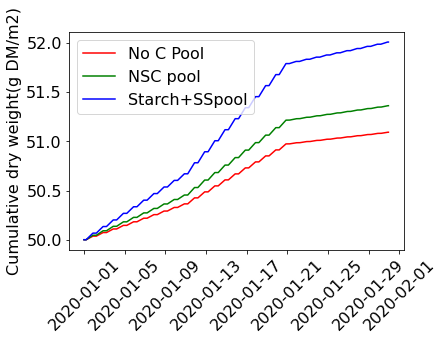

In [214]:
'''
Code plotting
'''

plt.plot(pd.Series(drymass1,df.index), 'r-',label = 'No C Pool')
plt.plot(pd.Series(drymass2,df.index), 'g-', label= 'NSC pool')
plt.plot(pd.Series(drymass3,df.index), 'b-', label = 'Starch+SSpool')
# plt.xlim(df.index[3],df.index[-1])
plt.legend()
plt.ylabel("Cumulative dry weight(g DM/m2)")
# plt.ylim(0,)
plt.xticks(rotation=45)
plt.show()